In [17]:
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, confusion_matrix
#Can be very helpful to notice any imbalance in classes
from collections import Counter
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from time import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt





We try to connect to PSQL

In [18]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='psql4.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

In [19]:
#Get the configuration file as a python dictionary
cfg = config()

In [20]:
#Establish the connection and create a cursor to the database
try:
    print("Here's an attempt to connect to the database")
    conn = psycopg2.connect(**cfg)
    cursor = conn.cursor()
    print("Look's like it was a success")

except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Here's an attempt to connect to the database
Look's like it was a success


In [21]:
try:
    cursor.execute("SELECT p.gender, p.age_group,\
                   l.city,\
                   w.max_temp, w.min_temp, w.total_rain_mm, w.total_snow_mm,\
                   f.fatal from covid19_tracking_fact_table as f inner join patient as p\
                   on f.patient_surrogate = p.patient_surrogate_key inner join phu_location as l\
                   on f.phu_surrogate = l.phu_surrogate_key inner join weather as w\
                   on f.weather_surrogate = w.surrogate_key")

    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()

except (Exception, psycopg2.DatabaseError) as error:
    print(error)

In [22]:
#Ensure to run this cell at the end of all your experiments to close all connections
cursor.close()
conn.close()

Set the DataFrame.

In [23]:
# We pick fatal as our Label, I think the individual physical fitness, local Medical level,
# the government's attitude towards disease and the weather will affect the death rate. Government special measures and local medical level
# can be included in city,
result_df = pd.DataFrame(result_list, columns=["gender", "age_group",
                                               "city",
                                               "max_temp", "min_temp", "total_rain_mm", "total_snow_mm",
                                               "fatal"])

Check what we have now

In [24]:
result_df.head()


,gender,age_group,city,max_temp,min_temp,total_rain_mm,total_snow_mm,fatal
0,MALE,50s,Newmarket,NaN,NaN,0.0,0.0,0
1,MALE,20s,Newmarket,NaN,NaN,0.0,0.0,0
2,MALE,<20,Newmarket,NaN,NaN,0.0,0.0,0
3,MALE,30s,Whitby,18.4,14.0,0.0,0.0,0
4,MALE,20s,Newmarket,NaN,NaN,0.0,0.0,0


Let check the missing value

In [25]:
#find the missing value
result_df.isnull().sum()

gender              0
age_group           3
city                0
max_temp         2692
min_temp         2692
total_rain_mm       0
total_snow_mm       0
fatal               0
dtype: int64

In [26]:
#and we check how many fatal we have
result_df['fatal'].sum()

1534

In [27]:
#then we check how many cases we have
len(result_df)

107349

In [28]:
# We see we have 107349 cases and only 2692 miss value, we try just drop
result_df = result_df.dropna()

In [29]:
result_df.isnull().sum()

gender           0
age_group        0
city             0
max_temp         0
min_temp         0
total_rain_mm    0
total_snow_mm    0
fatal            0
dtype: int64

In [30]:
#we check how many fatal we lost
result_df['fatal'].sum()
# we lost 50 fatal cases in a total number of 1534, it should be acceptable
# we can fillna with mean but I think fill missing value by mean value for max and min temp is not a good idea.

1484

In [31]:
# let see what we have now
result_df.head()
# Looks good

,gender,age_group,city,max_temp,min_temp,total_rain_mm,total_snow_mm,fatal
3,MALE,30s,Whitby,18.4,14.0,0.0,0.0,0
5,FEMALE,30s,Mississauga,17.6,11.6,0.0,0.0,0
6,MALE,40s,Mississauga,21.4,10.4,0.0,0.0,0
7,MALE,20s,Mississauga,21.1,11.5,0.0,0.0,0
10,FEMALE,30s,Mississauga,19.8,13.0,0.0,0.0,0


(array([5.2489e+04, 0.0000e+00, 0.0000e+00, 5.1748e+04, 0.0000e+00,
        0.0000e+00, 4.0400e+02, 0.0000e+00, 0.0000e+00, 1.3000e+01]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

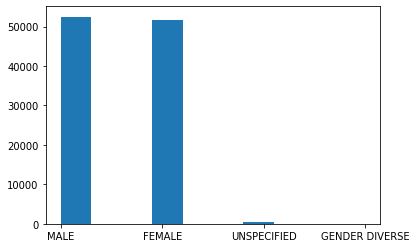

In [32]:
#data summarisation with histograms
plt.hist(result_df.gender)

(array([1.7130e+04, 1.5130e+04, 2.3136e+04, 1.5666e+04, 1.4937e+04,
        4.3550e+03, 9.1590e+03, 3.2610e+03, 1.8760e+03, 4.0000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

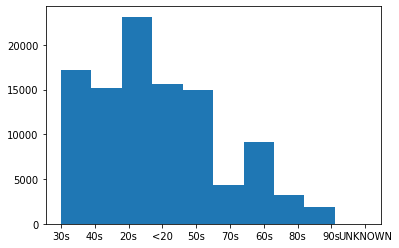

In [33]:
plt.hist(result_df.age_group)

(array([ 5470.,     0., 32763.,     0., 11896.,     0.,  4928.,     0.,
        42561.,  7036.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

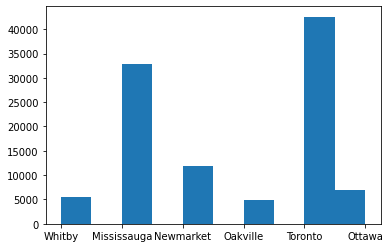

In [34]:
plt.hist(result_df.city)

(array([  191.,  2974., 11876., 29268., 21872., 11929.,  9924., 11900.,
         3406.,  1314.]),
 array([-10.5,  -6.5,  -2.5,   1.5,   5.5,   9.5,  13.5,  17.5,  21.5,
         25.5,  29.5]),
 <BarContainer object of 10 artists>)

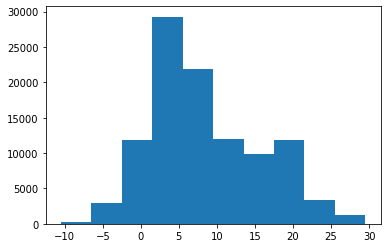

In [35]:
plt.hist(result_df.max_temp)

(array([   54.,   846.,  6951., 16207., 27576., 22857., 17942.,  8387.,
         3217.,   617.]),
 array([-18. , -14.2, -10.4,  -6.6,  -2.8,   1. ,   4.8,   8.6,  12.4,
         16.2,  20. ]),
 <BarContainer object of 10 artists>)

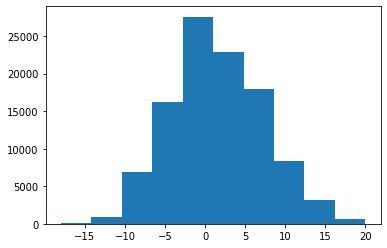

In [36]:
plt.hist(result_df.min_temp)

(array([9.9862e+04, 3.5190e+03, 6.6800e+02, 5.4900e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.6000e+01]),
 array([ 0.  ,  5.62, 11.24, 16.86, 22.48, 28.1 , 33.72, 39.34, 44.96,
        50.58, 56.2 ]),
 <BarContainer object of 10 artists>)

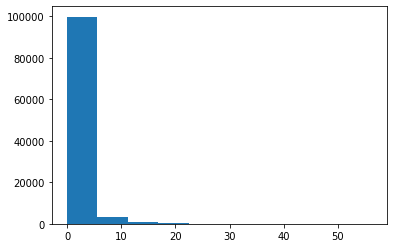

In [37]:
plt.hist(result_df.total_rain_mm)

(array([1.00962e+05, 1.40800e+03, 4.55000e+02, 4.25000e+02, 8.51000e+02,
        2.80000e+01, 2.50000e+01, 0.00000e+00, 3.35000e+02, 1.65000e+02]),
 array([  0. ,  22.4,  44.8,  67.2,  89.6, 112. , 134.4, 156.8, 179.2,
        201.6, 224. ]),
 <BarContainer object of 10 artists>)

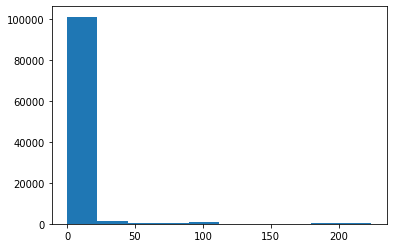

In [38]:
plt.hist(result_df.total_snow_mm)

(array([103170.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   1484.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

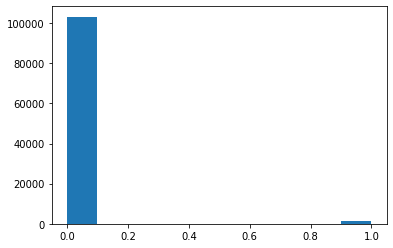

In [39]:
plt.hist(result_df.fatal)

Let's count the number of fatal


In [40]:
Counter(result_df['fatal'])

Counter({0: 103170, 1: 1484})

### labels is highly imbalanced, we will need undersampling later.

In [41]:
# take out the label
y = result_df['fatal']
#Drop the column for the next step
result_df.drop(columns=['fatal'], inplace=True)


In [42]:
result_df.head()# this is our features

,gender,age_group,city,max_temp,min_temp,total_rain_mm,total_snow_mm
3,MALE,30s,Whitby,18.4,14.0,0.0,0.0
5,FEMALE,30s,Mississauga,17.6,11.6,0.0,0.0
6,MALE,40s,Mississauga,21.4,10.4,0.0,0.0
7,MALE,20s,Mississauga,21.1,11.5,0.0,0.0
10,FEMALE,30s,Mississauga,19.8,13.0,0.0,0.0


In [43]:
# Our features have categorical data. We need to convert them to one-hot encoders to get the best results.
new_result_df = pd.get_dummies(result_df, prefix=["gender", "age_group", "city"])
new_result_df["max_temp"] = result_df["max_temp"]
new_result_df["min_temp"] = result_df["min_temp"]
new_result_df["total_rain_mm"] = result_df["total_rain_mm"]
new_result_df["total_snow_mm"] = result_df["total_rain_mm"]
new_result_df.head()

,max_temp,min_temp,total_rain_mm,total_snow_mm,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,age_group_20s,age_group_30s,...,age_group_80s,age_group_90s,age_group_<20,age_group_UNKNOWN,city_Mississauga,city_Newmarket,city_Oakville,city_Ottawa,city_Toronto,city_Whitby
3,18.4,14.0,0.0,0.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5,17.6,11.6,0.0,0.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
6,21.4,10.4,0.0,0.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,21.1,11.5,0.0,0.0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
10,19.8,13.0,0.0,0.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [44]:
# we need normalize the data to ensure all attributes are of equal importance during learning
new_result_df = new_result_df.apply(lambda  x:(x-x.min(axis=0))/(x.max(axis=0)-x.min(axis=0)))
#Get the X values
X = new_result_df.values
new_result_df.head()

,max_temp,min_temp,total_rain_mm,total_snow_mm,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,age_group_20s,age_group_30s,...,age_group_80s,age_group_90s,age_group_<20,age_group_UNKNOWN,city_Mississauga,city_Newmarket,city_Oakville,city_Ottawa,city_Toronto,city_Whitby
3,0.7225,0.842105,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.7025,0.778947,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.7975,0.747368,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.7900,0.776316,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.7575,0.815789,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


We are done with pre-processing of our data. Next, we need to devide our data to training and testing sets.

In [45]:
#first we def a function to show the recall, precision, accuracy and classification report
def print_scores(algorithms, yp, yt, t):
    print(algorithms)
    r = recall_score(yt, yp) * 100
    p = precision_score(yt, yp) * 100
    a = accuracy_score(yt,yp) * 100
    print("Recall {:.2f} %".format(r))
    print("precision {:.2f} %".format(p))
    print("accuracy {:.2f} %".format(a))
    print(classification_report(yt,yp))
    print("time to construct the {} mode {:.2f} s".format(algorithms,t))



We are done with pre-processing of our data. Next, we need to devide our data to training and testing sets.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({0: 82550, 1: 1173}) 
Test set Counter({0: 20620, 1: 311}) 


In [48]:
# now we do the undersampling

ns=NearMiss()
X_train_ns,y_train_ns=ns.fit_resample(X_train,y_train)
print(y_train.value_counts())
print(y_train_ns.value_counts())
# we see the cases of fatal and not fatal take the same number
# we dont change the sampling_strategy in NearMiss since we are not required to do it
# so we successfully remove the majority of cases.

0    82550
1     1173
Name: fatal, dtype: int64
1    1173
0    1173
Name: fatal, dtype: int64


In [49]:
#using Decision Tree
start = time()
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train_ns, y_train_ns)
y_pred=dt.predict(X_test)
end = time()
timing = end - start
print_scores("Decision Tree", y_pred, y_test, timing)

Decision Tree
Recall 80.71 %
precision 1.32 %
accuracy 9.86 %
              precision    recall  f1-score   support

           0       0.97      0.09      0.16     20620
           1       0.01      0.81      0.03       311

    accuracy                           0.10     20931
   macro avg       0.49      0.45      0.09     20931
weighted avg       0.95      0.10      0.16     20931

time to construct the Decision Tree mode 0.01 s


In [50]:
#using Gradient Boosting
start = time()
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
gb.fit(X_train_ns, y_train_ns)
y_pred=gb.predict(X_test)
end = time()
timing = end - start
print_scores("Gradient Boosting", y_pred, y_test, timing)

Gradient Boosting
Recall 60.77 %
precision 1.17 %
accuracy 22.95 %
              precision    recall  f1-score   support

           0       0.97      0.22      0.36     20620
           1       0.01      0.61      0.02       311

    accuracy                           0.23     20931
   macro avg       0.49      0.42      0.19     20931
weighted avg       0.96      0.23      0.36     20931

time to construct the Gradient Boosting mode 0.12 s


In [51]:
#using Random Forest
start = time()
rf = RandomForestClassifier(criterion='entropy')
rf.fit(X_train_ns, y_train_ns)
y_pred=rf.predict(X_test)
end = time()
timing = end - start
print_scores("Random Forest", y_pred, y_test, timing)


Random Forest
Recall 83.92 %
precision 1.28 %
accuracy 3.65 %
              precision    recall  f1-score   support

           0       0.91      0.02      0.05     20620
           1       0.01      0.84      0.03       311

    accuracy                           0.04     20931
   macro avg       0.46      0.43      0.04     20931
weighted avg       0.90      0.04      0.05     20931

time to construct the Random Forest mode 0.38 s


In [52]:
#One class SVM
#X = new_result_df.values
data = new_result_df.values
X, y = data[:,:-1],data[:,-1]
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X, y, test_size= 0.25)
print(X_train_o.shape, y_train_o.shape)
oc = OneClassSVM(nu=0.01)
y_oc = oc.fit_predict(X_train_o)
#print(y_oc)
mask = y_oc != -1
X_train_oc, y_train_oc = X_train_o[mask, :], y_train_o[mask]
print(X_train_oc.shape, y_train_oc.shape)
model = LinearRegression()
model.fit(X_train_oc,y_train_oc)
y_oc = model.predict(X_test_o)
mae = mean_absolute_error(y_test_o, y_oc)
print('MAE: %.3f' % mae)

count = len(y_train_o)-len(y_train_oc)
print('There are {} outliers'.format(count))

(78490, 23) (78490,)
(77488, 23) (77488,)
MAE: 0.000
There are 1002 outliers
